# University Related Coronavirus Sentiment Analysis
---

**Insert generic writeup here**

We are using the NLTK package in Python to do our natural language processing tasks in this project. Let's start with some basic setup

## Tokenizing the Data
---

There are numerous ways we can "clean" our data to make our final predicitions better. First, we will do what is called "tokenizing."
This process will take the Tweets as a whole, and split it into smaller subsections called tokens. These tokens make it much
easier for machines to understand the context of the text when developing the model.

In [1]:
# import pandas as pd
# # Extract content and date fields from csv
# fields=['date', 'content']
# d = pd.read_csv('combined_csv.csv', usecols=fields)

import nltk
nltk.download('twitter_samples')
from nltk.corpus import twitter_samples

positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')
text = twitter_samples.strings('tweets.20150430-223406.json')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/tucker/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


Fortunately, NLTK contains another helpful resource known as ```punkt```. This is a pre-trained model that allows us to easily tokenize our data.

To get the ```punkt``` resrouce, we run the following command:

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/tucker/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Now we are able to utilize NLTK's powerful tokenization tools. We simply use the ```.tokenized()``` method in order to tokenize our data.

To demonstrate how this works, let's tokenize ```negative_tweets.json```

In [3]:
print('Not Tokenized:')
print(twitter_samples.strings('negative_tweets.json')[0])   # String
print()
print('Tokenized:')
print(twitter_samples.tokenized('negative_tweets.json')[0]) # The same string, tokenized

Not Tokenized:
hopeless for tmr :(

Tokenized:
['hopeless', 'for', 'tmr', ':(']


Let's go ahead and tokenize ```positive_tweets.json``` for later:

In [4]:
tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
print(tweet_tokens[0])

['#FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', ':)']


## Normalizing the Data
---

Normalization, in terms of natural language processing, is the process of transforming a text into a canonical (standard) form.
For example, "gooood," and "gud" can be resolved to the normalized form "good." This can also apply for different tenses of the same word. For example, "ran," "runs," and "running" are all forms of "run."

<br/>

#### There are a few things at work here:

Stemming is the process of removing suffixes and prefixes from words. As an example, it reduces the inflection in words such as "troubled" and "troubles" to their root form "trouble."

Here are some stemming examples made using Porters Algorithm, one of the most common stemming algorithms:

<html>
<img src="Documents/StemmingExample.PNG" alt="drawing" width="275"/>
</html>

Lemmatization is similar to stemming, but rather than just cutting off the affixes, it will transform the word to it's root. As an example, it may transform the word "better" to "good."

Here are some examples of lemmatization using a dictionary mapping for the translations:

<html>
<img src="Documents/LemmatizationExample.PNG" alt="drawing" width="275"/>
</html>

<br/>
<br/>


This processing is essential for noisy social-media posts, as abbreviations and mispellings are very common!

We will be using lemmatization for our data, so let's download ```wordnet```, a lexical database, and ```averaged_perceptron_tagger```, which will help us in determining context

In [5]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /home/tucker/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/tucker/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Before using the lemmatizer, we must determine the context of each word within our tweets. To do this, we use what's called a tagging algorithm. Fortunately, NLTK provides a function for this.

Let's test it here:

In [6]:
from nltk.tag import pos_tag
print(pos_tag(tweet_tokens[0]))

[('#FollowFriday', 'JJ'), ('@France_Inte', 'NNP'), ('@PKuchly57', 'NNP'), ('@Milipol_Paris', 'NNP'), ('for', 'IN'), ('being', 'VBG'), ('top', 'JJ'), ('engaged', 'VBN'), ('members', 'NNS'), ('in', 'IN'), ('my', 'PRP$'), ('community', 'NN'), ('this', 'DT'), ('week', 'NN'), (':)', 'NN')]


Here are some common tags and their meaning:
- NNP: Noun, proper, singular
- NN: Noun, common, singular or mass
- IN: Preposition or conjunction, subordinating
- VBG: Verb, gerund or present participle
- VBN: Verb, past participle

Using the fact that tags starting with ``NN`` are typically nouns, and tags starting with ```VB``` are typically verbs, we can incorporate this into a function to lemmatize our data:

In [7]:
from nltk.stem.wordnet import WordNetLemmatizer

def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

This function gets the position tag of each token in the tweet, and lemmatizes accordingly.
Let's test it here:

In [8]:
print(lemmatize_sentence(tweet_tokens[0]))

['#FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'be', 'top', 'engage', 'member', 'in', 'my', 'community', 'this', 'week', ':)']


## Removing Noise from the Data
---

There is a lot of noise in tweets. Things such as hyperlinks, twitter handles, and some punctuation must be removed. That is what we will do here

To remove hyperlinks, we'll search for substrings ```http://``` and ```https://``` followed by the rest of the address. Once found, we will replace with an empty string.

In [9]:
import re, string

def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

This function removes noise and also incorporates the normalization and lemmatization as seen earlier. As arguments, it takes Tweet tokens and a stop words tuple.

Once again, NLTK is of great help here, as it provides a great stopwords set for us to use.

In [10]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/tucker/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Let's briefly test this:

In [11]:
print(tweet_tokens[0])
print()
print(remove_noise(tweet_tokens[0], stop_words))

['#FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', ':)']

['#followfriday', 'top', 'engage', 'member', 'community', 'week', ':)']


Now, we've removed all mentions, removed all stop words, and have made everything lowercase.

Next, let's go ahead and use this function to clean up the Tweets we saved earlier:

In [12]:
positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')

positive_cleaned_tokens_list = []
negative_cleaned_tokens_list = []

for tokens in positive_tweet_tokens:
    positive_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

for tokens in negative_tweet_tokens:
    negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

In [13]:
print(positive_tweet_tokens[0])
print()
print(positive_cleaned_tokens_list[0])

['#FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', ':)']

['#followfriday', 'top', 'engage', 'member', 'community', 'week', ':)']


Much, much better! All of this processing will allow our model to be much more accurate!

## Word Density
---

One of the simplest forms of textual analysis is a simple word frequency. Let's take a look at the frequencies of words in some of these data sets.

In [14]:
def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token

all_pos_words = get_all_words(positive_cleaned_tokens_list)
all_neg_words = get_all_words(negative_cleaned_tokens_list)

This is a generator function which will take a list of tokens as an argument and will provide a list of all of the words.

Now that we've combined all of the positive tweets, let's see what the most popular ones are. Once again, NLTK comes to the rescue!

[(':)', 3691), (':-)', 701), (':d', 658), ('thanks', 388), ('follow', 357), ('love', 333), ('...', 290), ('good', 283), ('get', 263), ('thank', 253), ('u', 245), ('day', 242), ('like', 229), ('see', 195), ('happy', 192)]


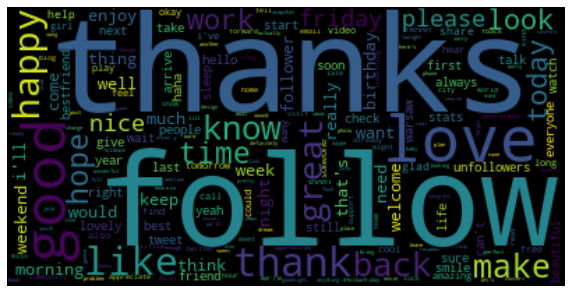

In [15]:
from nltk import FreqDist
from wordcloud import WordCloud
from matplotlib import pyplot as plt

freq_dist_pos = FreqDist(all_pos_words)
print(freq_dist_pos.most_common(15))


filter_words = dict([(m, n) for m, n in freq_dist_pos.items() if len(m) > 3])
wcloud = WordCloud().generate_from_frequencies(filter_words)

# Plotting the wordcloud
plt.figure(figsize=(10, 10))
plt.imshow(wcloud, interpolation="bilinear")
plt.axis("off")
# (-0.5, 399.5, 199.5, -0.5)
plt.show()

And now for the negatives:

[(':(', 4585), (':-(', 501), ("i'm", 343), ('...', 332), ('get', 325), ('miss', 291), ('go', 275), ('please', 275), ('want', 246), ('like', 218), ('♛', 210), ('》', 210), ('u', 193), ("can't", 180), ('time', 160)]


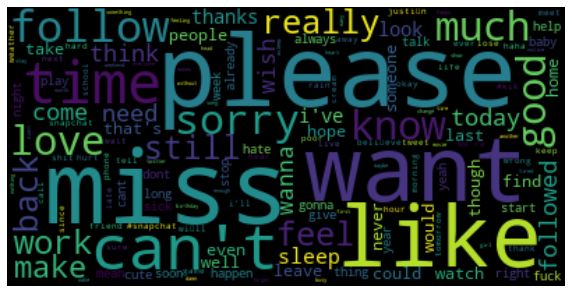

In [16]:
freq_dist_neg = FreqDist(all_neg_words)
print(freq_dist_neg.most_common(15))

filter_words = dict([(m, n) for m, n in freq_dist_neg.items() if len(m) > 3])
wcloud = WordCloud().generate_from_frequencies(filter_words)

# Plotting the wordcloud
plt.figure(figsize=(10, 10))
plt.imshow(wcloud, interpolation="bilinear")
plt.axis("off")
# (-0.5, 399.5, 199.5, -0.5)
plt.show()

Interesting. It's clear that emoticons are very common in both positive and negative Tweets. It's very interesting how you can begin to see some overall sentiment just from this frequency analysis, with the positive Tweets commonly having words such as "thanks," "love, " and "happy."

So, to summarize a bit, so far we have extracted tweets from NLTK, tokenized them, normalized them, and cleaned them up. Then, we looked at some basic frequency analysis. Let's move on to modeling!

## Prepping for Model
---

To make a model, we need to create a training set to train our model. This is known as supervised learning, the task of learning a function that maps an input to an output based on example input-output pairs. We must associate our datasets with a sentiment, and these is where our datasets of positive and negative datasets comes in. Here, we will train our model to classify into two categories, positive and negative. In order to do this, we will need to split our dataset into parts, one part for training the model and the another part for testing its accuracy.

We will be using the Naive Bayes Classifier in NLTK. If you've taken a statistics class, you've probably heard of Bayes' Thereom, and that is what this classifier is based on.

To use the Naive Bayes Classfier in NLTK, we must ocnvert our tokens to a dictionary with the words being the keys and the value being True.

Let's create a generator function which will convert the clean tokens to dictionaries with the words being the keys and the values all being True:

In [17]:
def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

As mentioned earlier, we have to split our dataset. Part of it will be used for training, and the other for testing.

In [18]:
import random

positive_dataset = [(tweet_dict, "Positive")
                     for tweet_dict in positive_tokens_for_model]

negative_dataset = [(tweet_dict, "Negative")
                     for tweet_dict in negative_tokens_for_model]

dataset = positive_dataset + negative_dataset

random.shuffle(dataset)

train_data = dataset[:7000]
test_data = dataset[7000:]

This attaches a sentiment to each tweet, and then combines them. To avoid bias, the combines dataset is shuffled.

After the above code runs, we have 10,000 Tweets to build our model. 7,000 will be used for training while the remaining 3,000 will be used for testing.

After all of this setup, we are finally to the point where we will build our model. We'll use some handy NLTK functions here: ```train()``` and ```accuracy```.

## Building and Testing our Model
---

In [19]:
from nltk import classify
from nltk import NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(train_data)

print("Accuracy is:", classify.accuracy(classifier, test_data))

print(classifier.show_most_informative_features(10))

Accuracy is: 0.9926666666666667
Most Informative Features
                      :( = True           Negati : Positi =   2054.9 : 1.0
                      :) = True           Positi : Negati =   1666.9 : 1.0
                     sad = True           Negati : Positi =     32.6 : 1.0
                follower = True           Positi : Negati =     21.7 : 1.0
                    sick = True           Negati : Positi =     20.1 : 1.0
                  arrive = True           Positi : Negati =     18.4 : 1.0
                     x15 = True           Negati : Positi =     16.8 : 1.0
                     via = True           Positi : Negati =     16.6 : 1.0
                 welcome = True           Positi : Negati =     14.3 : 1.0
                     idk = True           Negati : Positi =     12.8 : 1.0
None


The accuracy which was outputted above is the percentage of tweets that the model was correct. 99.7%, not too bad!

We also outputted the most informative features. This shows the ratio of that specific tokens occurence in the positive dataset to the negative dataset. Some more interesting insight into our data here!

Finally, we are to the point that we can pass our classifier a Tweet, and it will return it's sentiment. Let's Test it out!

We'll write our own example for a postive and negative tweet:

In [20]:
negative_tweet = 'Today was a terrible day! I spent forever trying to get my Jupyter Notebook to run properly, but it wouldn\'t budge! :('
positive_tweet = 'Today was amazing! I\'m very happy! :)'
                                                                                                                                        
from nltk.tokenize import word_tokenize

tokens = remove_noise(word_tokenize(negative_tweet))

print(classifier.classify(dict([token, True] for token in tokens)))
                                                                                                                                        
tokens = remove_noise(word_tokenize(positive_tweet))

print(classifier.classify(dict([token, True] for token in tokens)))

Negative
Positive


Working as intended!

With our model set up and working, let's move on to using it for something cool!

## Reading in and Classifying our Data
---

As mentioned earlier, we are comparing two datasets. One dataset containing Tweets from accounts which are directly associated or owned by the University, and the other containing Tweets which are related to the university, but not directly associated or owned by the university.

For the tweets from accounts which are directly associated or owned by the University, we searched for Tweets from these accounts:

Administration:
- @DondePlowman - Donde Plowman
- @randyboyd - Randy Boyd
- @tucarpenter - Tiffany Carpenter
- @UTIA_SVP - Tim Cross
- @KC4UTM - Keith Carver

University Accounts:
- @utknoxville
- @utk_tce
- @utkdos
- @ut_admissions
- @utk_asc
- @UTKCEHHS
- @utk_cfs
- @UTKStudentLife
- @UTKCoAD
- @UTKSOM
- @tennalum
- @utknursing
- @HaslamUT

For the tweets from accounts which are not directly associated or owned by the University, we searched for Tweets with these keywords
- keyword1
- keyword2
- keyword3...

This data was colleced using the snscrape command line tool, and historically represent the time period of August 1st, 2019 to August 1st, 2020

Now that we, have our data in CSVs, let's use Pandas to read them in:

In [21]:
import pandas as pd
# Extract content and date fields from csv
fields=['date', 'content', 'user/username']
d = pd.read_csv('combined_csv.csv', usecols=fields)

# Create dataframe
tweets_df = pd.DataFrame(data=d)
tweets_df

,date,content,user/username
0,2020-08-10T14:13:27+00:00,Marcus Yoder (HCB ‘92) has been appointed seni...,HaslamUT
1,2020-08-07T19:30:08+00:00,Congratulations to the Haslam College of Busin...,HaslamUT
2,2020-08-07T14:14:23+00:00,#FacultyFriday Supply chain management profess...,HaslamUT
3,2020-08-06T19:37:43+00:00,"Due to COVID-19, most internships have switche...",HaslamUT
4,2020-08-06T14:40:37+00:00,Congratulations to MSCM Tri-Con grad Nainika S...,HaslamUT
...,...,...,...
7038,2019-08-04T11:55:30+00:00,2 weeks from tonight is Torch Night. “One that...,DondePlowman
7039,2019-08-03T17:07:33+00:00,This is great news Tom. Thanks for the update....,DondePlowman
7040,2019-08-02T22:56:37+00:00,Having a partner who is the love of your life ...,DondePlowman
7041,2019-08-02T16:39:28+00:00,So impressed with the crowd &amp; the passion ...,DondePlowman


Let's use our model and add a column to our dataframe which represents the sentiment of each Tweet:

In [22]:
sentiment = []
tweets = tweets_df['content'].tolist()
for tweet in tweets:
    tokens = remove_noise(word_tokenize(tweet))
    sentiment.append(classifier.classify(dict([token, True] for token in tokens)))
    
tweets_df['sentiment'] = sentiment
tweets_df

,date,content,user/username,sentiment
0,2020-08-10T14:13:27+00:00,Marcus Yoder (HCB ‘92) has been appointed seni...,HaslamUT,Negative
1,2020-08-07T19:30:08+00:00,Congratulations to the Haslam College of Busin...,HaslamUT,Positive
2,2020-08-07T14:14:23+00:00,#FacultyFriday Supply chain management profess...,HaslamUT,Positive
3,2020-08-06T19:37:43+00:00,"Due to COVID-19, most internships have switche...",HaslamUT,Negative
4,2020-08-06T14:40:37+00:00,Congratulations to MSCM Tri-Con grad Nainika S...,HaslamUT,Positive
...,...,...,...,...
7038,2019-08-04T11:55:30+00:00,2 weeks from tonight is Torch Night. “One that...,DondePlowman,Positive
7039,2019-08-03T17:07:33+00:00,This is great news Tom. Thanks for the update....,DondePlowman,Positive
7040,2019-08-02T22:56:37+00:00,Having a partner who is the love of your life ...,DondePlowman,Positive
7041,2019-08-02T16:39:28+00:00,So impressed with the crowd &amp; the passion ...,DondePlowman,Positive


Let's also take a quick look at the overall counts:

  Sentiment Count
0  Positive  5162
1  Negative  1881


<AxesSubplot:ylabel='Count'>

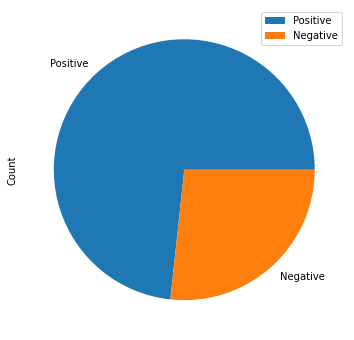

In [23]:
# tweets_df['sentiment'].value_counts()
proportions_df = pd.DataFrame(tweets_df['sentiment'].value_counts().reset_index().values, columns=["Sentiment", "Count"])
print(proportions_df)
proportions_df.plot.pie(y='Count', labels=proportions_df['Sentiment'], figsize=(6,6))


Nice! Now we have associated a sentiment with each of these Tweets, as seen above!

Pandas doesn't like ISO 8601 time format, so let's use a lambda to change the dates to something readable by Pandas:

In [24]:
import dateutil.parser
# Convert ISO 8601 time format to be readable by pandas
tweets_df['date'] = tweets_df['date'].apply(lambda x: dateutil.parser.parse(x))

Let's use groupby to get the number of positive and negative Tweets for each week in our time period:

In [27]:
tweets_df['month/year'] = tweets_df['date'].apply(lambda x: "%d/%d" % (x.month, x.year))
# TODO: move months down to plot since only used for labeling now
months = ['8/2019', '9/2019', '10/2019', '11/2019', '12/2019', '1/2020', '2/2020', '3/2020', '4/2020', '5/2020', '6/2020', '7/2020', '8/2020']
# mapping = {day: i for i, day in enumerate(months)}

tweets_df_grouped = tweets_df.groupby(['month/year', 'sentiment']).size()
tweets_df_grouped

month/year  sentiment
1/2020      Negative     136
            Positive     387
10/2019     Negative     173
            Positive     440
11/2019     Negative     141
            Positive     496
12/2019     Negative     153
            Positive     267
2/2020      Negative     126
            Positive     376
3/2020      Negative     214
            Positive     619
4/2020      Negative     212
            Positive     491
5/2020      Negative     133
            Positive     491
6/2020      Negative     122
            Positive     333
7/2020      Negative     117
            Positive     320
8/2019      Negative     158
            Positive     402
8/2020      Negative      40
            Positive     101
9/2019      Negative     156
            Positive     439
dtype: int64

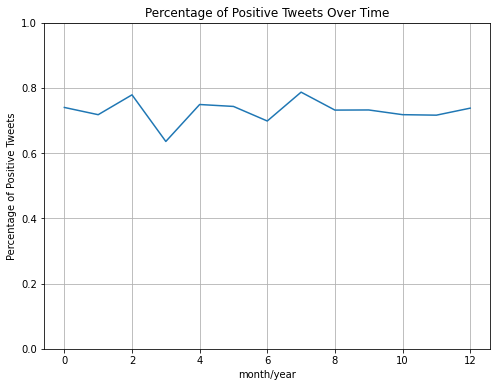

In [97]:
import numpy as np
from matplotlib import pyplot as plt

N = 2
count_tuples = [tweets_df_grouped.values[n:n+N] for n in range(0, len(tweets_df_grouped.values), N)]

pos_percentages = []
for group in count_tuples:
#     print('{} divided by {}'.format(group[1], sum(group)))
    pos_percentages.append(group[1] / sum(group))

plt.figure(figsize=(8,6))
plt.plot(pos_percentages)
# plt.xticks(np.arange(13), months, rotation=45)
plt.ylim(0, 1)
plt.xlabel('month/year')
plt.ylabel('Percentage of Positive Tweets')
plt.title('Percentage of Positive Tweets Over Time')
plt.grid()
plt.show()

[Text(0, 0, '8/2019'),
 Text(1, 0, '9/2019'),
 Text(2, 0, '10/2019'),
 Text(3, 0, '11/2019'),
 Text(4, 0, '12/2019'),
 Text(5, 0, '1/2020'),
 Text(6, 0, '2/2020'),
 Text(7, 0, '3/2020'),
 Text(8, 0, '4/2020'),
 Text(9, 0, '5/2020'),
 Text(10, 0, '6/2020'),
 Text(11, 0, '7/2020'),
 Text(12, 0, '8/2020')]

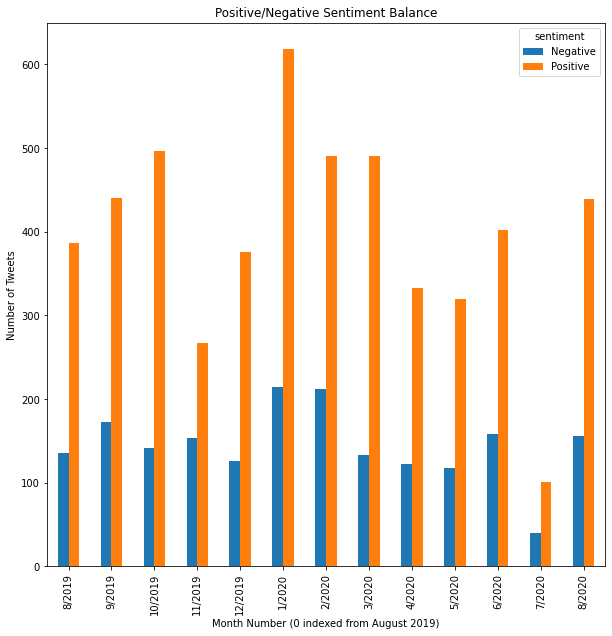

In [29]:
ax = tweets_df_grouped.unstack().plot.bar(xlabel='Month Number (0 indexed from August 2019)',\
                                     ylabel='Number of Tweets',\
                                     title='Positive/Negative Sentiment Balance',\
                                     figsize=(10, 10))
ax.set_xticklabels(months)

Interesting graphic here! There the ratio of positive to negative Tweets is very one sided in most months, but is at its highest in March, around the beginning of the pandemic. We propose this could be due to encouragement from campus leaders to stay strong when things were beginning to get rough, and to continue with the constant encouragement they tend to display. Also, we noticed a low level of negative Tweets in August, the beginning of the semester. However, the full month of August 2020 was not included in our collection process.

The two most heavily positive months were September 2019 and March 2020. Out of curiosity, and becasue of the fact that we 
really began to feel the pressure of the pandemic in march, let's take a closer look at that month specifically:

<ipython-input-126-5e579ab4a233>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['day'] = test['date'].apply(lambda x: "%d" % (x.day))
<ipython-input-126-5e579ab4a233>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['day'] = test['day'].astype(int)


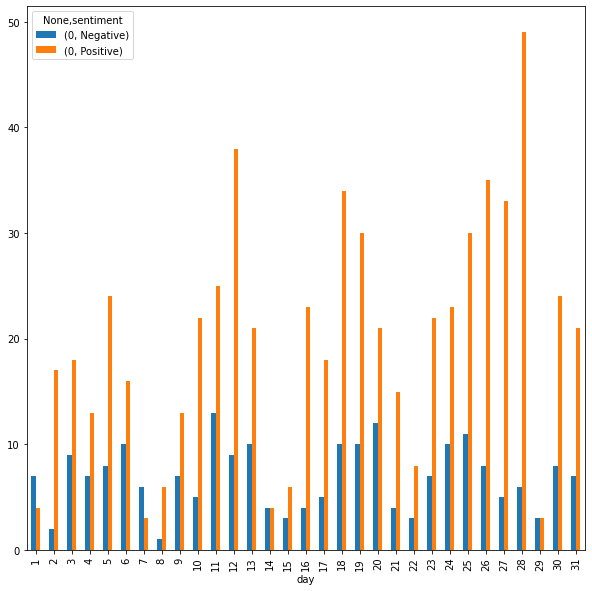

In [126]:
# Create boolean mask to filter out March
mask = (tweets_df['month/year'] == '3/2020')
# tweets_df[mask]

# W-MON weekly frequency (Mondays)
# weeks_march = tweets_df[mask].groupby('sentiment').resample('W-Mon', on='date').size().reset_index()
# weeks_march.T

# test = tweets_df[mask].groupby(['date', 'sentiment']).size()
# test

test = tweets_df[mask]
test['day'] = test['date'].apply(lambda x: "%d" % (x.day))
test['day'] = test['day'].astype(int)
test = test.sort_values(by='day')
test

test_grouped = test.groupby(['day', 'sentiment']).size()
test_grouped = test_grouped.to_frame()
test_grouped

ax = test_grouped.unstack().plot.bar(figsize=(10, 10))

# tweets_df_grouped = tweets_df.groupby(['month/year', 'sentiment']).size()

# NOTE: Wed March 11 was initial extension of break. Monday March 16 was announcement of online through end of semester


---

Now, let's do the same thing with our datset of Tweets from non admin/uni Tweets:

In [ ]:
import pandas as pd
# Extract content and date fields from csv
fields=['date', 'content', 'user/username']
d = pd.read_csv('combinedNonUni_csv.csv', usecols=fields)

# Create dataframe
tweets_df = pd.DataFrame(data=d)
tweets_df

sentiment = []
tweets = tweets_df['content'].tolist()
for tweet in tweets:
    tokens = remove_noise(word_tokenize(tweet))
    sentiment.append(classifier.classify(dict([token, True] for token in tokens)))
    
tweets_df['sentiment'] = sentiment
# tweets_df

tweets_df['sentiment'].value_counts()

import dateutil.parser
# Concert ISO 8601 time format to be readable by pandas
tweets_df['date'] = tweets_df['date'].apply(lambda x: dateutil.parser.parse(x))
# pd.set_option("display.max_rows", None, "display.max_columns", None)

tweets_df.sort_values(by=['date'])


# tweets_df['month/year'] = tweets_df['date'].apply(lambda x: "%d/%d" % (x.month, x.year))
# months = ['8/2019', '9/2019', '10/2019', '11/2019', '12/2019', '1/2020', '2/2020', '3/2020', '4/2020', '5/2020', '6/2020', '7/2020', '8/2020']
# mapping = {day: i for i, day in enumerate(months)}
# tweets_df['month/year'] = tweets_df['month/year'].map(mapping)
# # tweets_df


# tweets_df_grouped = tweets_df.groupby(['month/year', 'sentiment']).size()
# tweets_df_grouped

# tweets_df_grouped.unstack().plot.bar(figsize=(10, 10))



The above analysis brings about some interesting discourse and gives us some nice visuals to analyze; however, there are a few drawbacks. The biggest of these drawbacks would be the fact that our model is a binary classifier, meaning it classifies the Tweets into only two categories, positive or negative. This can be misleading as neutral Tweets are common, and this approach forces the model to place one of these labels onto each Tweet.

However, there are more ways to analyze this, which we will get into now!

## Vader Sentiment Analysis
---

VADER (Valence Aware Dictionary and Sentiment Reasoner) is a very powerful tool which will allow us to analyze our data in a much more specific manner. Even better, this tool is specifically adapted to sentiments which are expressed in social media.

This analysis is based on lexicons of sentiment-related words. A lexicon is taken, and each word is ranked not only as positive or negative, but how positive and negative it may be.

Here's an example of some words, and their associated sentiment ratings:

<html>
<img src="Documents/Vader Lexicon Excerpt.PNG" alt="drawing" width="700"/>
</html>


These words have been manually rated by humans, and if VADER's lexicon provides good coverage of the words in your data, it provides accurate, quick results.

Let's test it out:

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# function to print sentiments 
# of the sentence. 
def sentiment_scores(sentence): 
  
    # Create a SentimentIntensityAnalyzer object. 
    sid_obj = SentimentIntensityAnalyzer() 
  
    # polarity_scores method of SentimentIntensityAnalyzer 
    # oject gives a sentiment dictionary. 
    # which contains pos, neg, neu, and compound scores. 
    sentiment_dict = sid_obj.polarity_scores(sentence) 
      
    print("Overall sentiment dictionary is : ", sentiment_dict) 
    print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative") 
    print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral") 
    print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive") 
  
    print("Sentence Overall Rated As", end = " ") 
  
    # decide sentiment as positive, negative and neutral 
    if sentiment_dict['compound'] >= 0.05 : 
        print("Positive") 
  
    elif sentiment_dict['compound'] <= - 0.05 : 
        print("Negative") 
  
    else : 
        print("Neutral") 

The above function takes the sentence argument, uses VADER to analyze it, and prints out the results

In [ ]:
sentence = "Today was an amazing day! The weather was nice, and we all had a blast :)"
sentiment_scores(sentence)

You can see that the text is given a rating for negative, neutral, and positive. The compound number is a representation of all 3. It is normalized to be between -1 and 1, the closer to -1 the more negative, the closer to 1 the more positive, and the closer to 0 the more neutral.

This will enable us to get a better look at the historic sentiment of our Tweets. Let's first analyze the Tweets of our admin/university sanctioned dataset. We'll set that up here:

In [ ]:
# Extract content and date fields from csv
fields=['date', 'content']
d = pd.read_csv('combined_csv.csv', usecols=fields)

# Create dataframe
tweets_df = pd.DataFrame(data=d)

# Calculate polarity scores and store compound result into vals
sid_obj = SentimentIntensityAnalyzer() 

vals = []

tweets = tweets_df['content'].tolist()
for tweet in tweets:
    sentiment_dict = sid_obj.polarity_scores(tweet)
    vals.append(sentiment_dict['compound'])

# Add vals to dataframe
tweets_df['compound'] = vals 

# Concert ISO 8601 time format to be readable by pandas
tweets_df['date'] = tweets_df['date'].apply(lambda x: dateutil.parser.parse(x))

# Set index as the data
tweets_df.index = tweets_df['date']

# Drop content column and resample on a weekly basis, calculating the mean of each month
data = tweets_df.drop(columns=['content']).resample('M').mean()

data.head()

And just like that, we have grouped our Tweets by week and have calculated the VADER compound score on each chunk.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

xticks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
labels = ['August \'19', 'September \'19', 'October \'19', 'November \'19', 'December \'19',
          'January \'20', 'February \'20', 'March \'20', 'April \'20', 'May \'20', 'June \'20',
          'July \'20', 'August \'20']


plt.figure(figsize=(8, 6))
plt.ylim(-1, 1)
plt.xticks(xticks, labels, rotation=45)
plt.grid()
# plt.plot(np.arange(1, 56), data)
plt.plot(np.arange(1, 14), data)
plt.xlabel('Week Number')
plt.ylabel('VADER Compound')
plt.title('VADER Compound Over Time')
plt.show()

put more data insight here... Pretty stable month-to-month, with the lowest overall sentiment being in December 2019

Do this for non admin, then plot both on same line chart and draw comparisons...

Now, moving on to our non admin/university sanctioned accounts:

In [ ]:
# # Extract content and date fields from csv
# fields=['date', 'content']
# d = pd.read_csv('tbd.csv', usecols=fields)

# # Create dataframe
# tweets_df2 = pd.DataFrame(data=d)

# # Calculate polarity scores and store compound result into vals
# sid_obj = SentimentIntensityAnalyzer() 

# vals = []

# tweets = tweets_df['content'].tolist()
# for tweet in tweets:
#     sentiment_dict = sid_obj.polarity_scores(tweet)
#     vals.append(sentiment_dict['compound'])

# # Add vals to dataframe
# tweets_df2['compound'] = vals 

# # Concert ISO 8601 time format to be readable by pandas
# tweets_df2['date'] = tweets_df2['date'].apply(lambda x: dateutil.parser.parse(x))

# # Set index as the data
# tweets_df2.index = tweets_df['date']

# # Drop content column and resample on a weekly basis, calculating the mean of each month
# data2 = tweets_df2.drop(columns=['content']).resample('M').mean()

# data.head()

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# xticks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
# labels = ['August \'19', 'September \'19', 'October \'19', 'November \'19', 'December \'19',
#           'January \'20', 'February \'20', 'March \'20', 'April \'20', 'May \'20', 'June \'20',
#           'July \'20', 'August \'20']


# plt.figure(figsize=(8, 6))
# plt.ylim(-1, 1)
# plt.xticks(xticks, labels, rotation=45)
# plt.grid()
# # plt.plot(np.arange(1, 56), data)
# plt.plot(np.arange(1, 14), data2)
# plt.xlabel('Week Number')
# plt.ylabel('VADER Compound')
# plt.title('VADER Compound Over Time')
# plt.show()